# Faster processing the message table using Dask

This notebook demonstrates use of Dask dataframes to speed up handling of the roughly 32 million xdmod job-task records. Dask is faster because it loads and processes chunks of the data in parallel. To support the use of dask, we have converted the xdmod table into [`parquet`](https://parquet.apache.org/) files in the directory `
/project/rcde/xdmod_analysis/jobs_with_hosts_parquet`. Parquet is just an efficient storage format for tabular data. I have broken the data into many small parquet files because this allows dask to perform many reads in parallel. 

The Dask dataframe API attempts to copy the pandas API as closely as possible. 

In [1]:
import pandas as pd
import dask.dataframe as dd
import os, shutil
import logging
import matplotlib.pyplot as plt

In [2]:
from dask.distributed import Client
client = Client()

In [3]:
ddf = dd.read_parquet('/project/rcde/xdmod_analysis/jobs_with_hosts_dialy_time/')

In [4]:
ddf

,job_task_id,pbs_job_id,host_id,hostname,queue,systemaccount_id,username,group_name,submit_time,wallduration,waitduration,requested_walltime,node_count,processor_count,gpu_count,mem_req,date,seconds
npartitions=323,,,,,,,,,,,,,,,,,,
,int32,int32,int32,object,object,int32,object,object,datetime64[ns],int32,int32,int32,int32,int32,int32,int32,object,int32
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
ddf.sample(frac=0.01).head()

,job_task_id,pbs_job_id,host_id,hostname,queue,systemaccount_id,username,group_name,submit_time,wallduration,waitduration,requested_walltime,node_count,processor_count,gpu_count,mem_req,date,seconds
86452,73376,4346332,665,node0664,c1_single,1013,zhenzhz,cuuser,2022-01-08 14:49:18,554987,9,720000,1,2,0,0,2022-01-09,86400
88590,75105,4373436,1571,node1591,c1_tiny,520,lcasabi,cuuser,2022-01-12 17:06:59,259241,3,259200,2,32,0,-2147483648,2022-01-12,24778
37924,30241,4346450,797,node0814,c1_solo,1013,zhenzhz,cuuser,2022-01-08 14:56:12,18,5,7200,1,1,0,0,2022-01-08,18
13704,11170,4314216,1101,node1118,c2_tiny,1015,zhiyuas,cuuser,2022-01-02 10:31:24,134185,85399,259200,16,101,0,-2147483648,2022-01-03,49517
68425,57449,4375204,495,node0494,c1_solo,875,stellaw,cuuser,2022-01-12 20:53:12,5819,10,360000,1,1,0,-1073741824,2022-01-12,5819


In [6]:
ddf.columns

Index(['job_task_id', 'pbs_job_id', 'host_id', 'hostname', 'queue',
       'systemaccount_id', 'username', 'group_name', 'submit_time',
       'wallduration', 'waitduration', 'requested_walltime', 'node_count',
       'processor_count', 'gpu_count', 'mem_req', 'date', 'seconds'],
      dtype='object')

In [17]:
len(ddf)

38846944

# Cleaning

In [7]:
# dtypes
ddf['date'] = dd.to_datetime(ddf['date'])

# derived metrics
ddf['cpus_per_node'] = ddf['processor_count'] / ddf['node_count']
ddf['gpus_per_node'] = ddf['gpu_count'] / ddf['node_count']
ddf['cpu_hours'] = ddf['cpus_per_node'] * ddf['seconds'] / 3600
ddf['gpu_hours'] = ddf['gpus_per_node'] * ddf['seconds'] / 3600

# Resource Use

## Total Hours

In [11]:
# Total CPU hours in 2023-01-01 through 2023-04-31. Compare with 55.9MM on xdmod
ddf.query("date >= '2023-01-01 00:00:00' and date < '2023-05-01 00:00:00'").cpu_hours.sum().compute()

55943386.49138889

In [12]:
# Total GPU hours in 2023-01-01 through 2023-04-31. Compare with 996,467 on xdmod
ddf.query("date >= '2023-01-01 00:00:00' and date < '2023-05-01 00:00:00'").gpu_hours.sum().compute()

996694.9783333332

## Top Users

In [15]:
# Top cpu users in 2023
top_cpu_users = ddf.\
    query("date > '2023-01-01 00:00:00'").\
    groupby('username').\
    cpu_hours.sum().\
    compute().\
    sort_values(ascending=False)

In [16]:
top_cpu_users.head(30)/(24*365)

username
osg001           880.514698
conorbready      548.994273
ncavana          468.161475
swang8           211.161451
nkarthi          206.294726
georgeshields    201.903160
rmotwan          194.906900
pkoiral          178.863523
nwen             131.532976
rsadiwa          130.398054
jtessen          130.275353
odonne9          127.238863
fding            125.331302
svicchi          122.584843
zhiyuas          120.773659
dzegan           118.651269
peix             114.231272
zhongth          110.512337
belbrec          107.072146
wester5          106.401208
tgupta           105.720330
zhiminc          101.761334
sanchab           94.516124
michaelbarton     94.312397
yunxias           92.431935
dzhang4           87.260105
soumits           87.237402
zfeng             86.670471
rsivara           78.323474
lmorand           72.997516
Name: cpu_hours, dtype: float64

In [20]:
# Top gpu users in 2023
top_gpu_users = ddf.\
    query("date > '2023-01-01 00:00:00'").\
    groupby('username').\
    gpu_hours.sum().\
    compute().\
    sort_values(ascending=False)

In [21]:
top_gpu_users.head(30)/(24*365)

username
rsivara          10.569558
leob              8.624443
belbrec           6.692009
tgupta            6.297920
ckosgal           6.243530
ncavana           5.968453
peix              5.417927
oopetub           5.399741
wester5           5.364631
dylandaw          5.259106
enrique           4.367672
zhiminc           4.109560
dzhang4           4.054935
zhongth           3.745327
dzegan            3.000616
antianw           2.978590
zfeng             2.768642
jwfisch           2.542058
jpandre           2.301820
lsutto2           2.248984
gsasko            2.242212
jha5              2.111234
mingqil           1.789454
tylerluchko       1.733919
georgeshields     1.730321
soumits           1.685899
nlinton           1.615633
ohussei           1.603952
agholam           1.562561
zeng4             1.539124
Name: gpu_hours, dtype: float64

## Use through time

In [22]:
# compute hours through time
ddf['start_year'] = ddf.date.dt.year
ddf['start_month'] = ddf.date.dt.month

df_t = ddf.\
    query("date > '2020-01-01 00:00:00'").\
    groupby(['start_year', 'start_month'])['cpu_hours', 'gpu_hours'].\
    sum().\
    compute().\
    reset_index()

In [23]:
df_t['date'] = pd.to_datetime(df_t.apply(lambda x: f"{int(x.start_year)}-{int(x.start_month)}-01", axis=1))
df_t = df_t.sort_values('date')

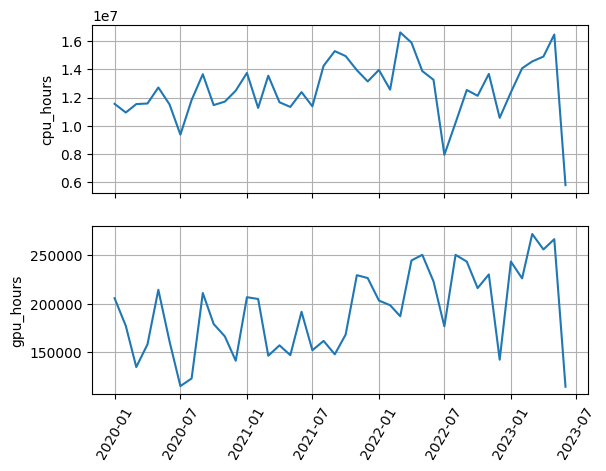

In [24]:
fig, ax = plt.subplots(2, sharex=True, sharey=False)
for ix, c in enumerate(('cpu_hours', 'gpu_hours')):
    ax[ix].plot(df_t['date'], df_t[c])
    ax[ix].set_ylabel(c)
    ax[ix].grid()
    
_ = plt.xticks(rotation=60)

## Wait times

In [25]:
# wait duration through time
df_t = ddf.\
    query("date > '2020-01-01 00:00:00'").\
    drop_duplicates(subset=['job_task_id', 'waitduration']).\
    groupby(['start_year', 'start_month']).\
    waitduration.mean().\
    compute().\
    reset_index()

In [26]:
df_t

,start_year,start_month,waitduration
0,2020,1,8049.713203
1,2020,2,8375.175018
2,2020,3,8684.155682
3,2020,4,11061.109845
4,2020,5,9189.659437
5,2020,6,9054.321919
6,2020,7,18753.658646
7,2020,8,5461.943130
8,2020,9,12745.057105
9,2020,10,4283.750367


In [27]:
df_t['date'] = pd.to_datetime(df_t.apply(lambda x: f"{int(x.start_year)}-{int(x.start_month)}", axis=1))
df_t = df_t.sort_values('date')

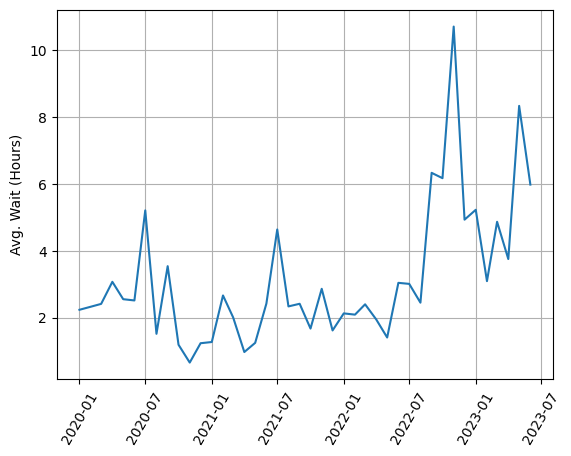

In [28]:
plt.plot(df_t.date, df_t.waitduration/3600)
plt.xticks(rotation=60)
plt.ylabel("Avg. Wait (Hours)")
plt.grid()